In [38]:
%matplotlib inline
import os
import json
from pprint import pprint
from ujson import load as json_load
import collections
import matplotlib.pyplot as plt
import numpy as np
import csv
from matplotlib.pyplot import figure
import seaborn as sns



#plt.rcParams['figure.figsize'] = [30, 15]

In [169]:
def load_dev(filepath):
    data = json.load(open(filepath))
    truth_dict = {}
    for k, v in data.items():
        truth_dict[v['uuid']] = {'answers': v['answers'], 'question':v['question'], 'context':v['context']}
    return truth_dict
        

In [201]:
def load_pred(filepath):
    preds = {}
    with open(filepath, newline='', encoding='utf-8') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
        count = 0
        for row in spamreader:
            if count ==0:
                count += 1
            else:
                preds[row[0]] = row[1]
    return preds

In [202]:
from __future__ import print_function
from collections import Counter
import string
import re
import argparse
import json
import sys

In [203]:
def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

In [204]:

def get_tokens(s):
    if not s:
        return []
    return normalize_answer(s).split()

def compute_em(a_gold, a_pred):
    return int(normalize_answer(a_gold) == normalize_answer(a_pred))

def compute_f1(a_gold, a_pred):
    gold_toks = get_tokens(a_gold)
    pred_toks = get_tokens(a_pred)
    common = Counter(gold_toks) & Counter(pred_toks)
    num_same = sum(common.values())
    if len(gold_toks) == 0 or len(pred_toks) == 0:
        # If either is no-answer, then F1 is 1 if they agree, 0 otherwise
        return int(gold_toks == pred_toks)
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(pred_toks)
    recall = 1.0 * num_same / len(gold_toks)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

def compute_avna(prediction, ground_truths):
    """Compute answer vs. no-answer accuracy."""
    return float(bool(prediction) == bool(ground_truths))

def metric_max_over_ground_truths(metric_fn, prediction, ground_truths):
    if not ground_truths:
        return metric_fn(prediction, '')
    scores_for_ground_truths = []
    for ground_truth in ground_truths:
        score = metric_fn(prediction, ground_truth)
        scores_for_ground_truths.append(score)
    return max(scores_for_ground_truths)


In [205]:
def eval_dicts(gold_dict, pred_dict, no_answer):
    avna = f1 = em = total = 0
    dict_quest = {}
    for key, value in pred_dict.items():
        total += 1
        ground_truths = gold_dict[key]['answers']
#         print(key)
#         print("prediction = ", value)
#         print("ground_truth = ", ground_truths)
        prediction = value
        em1 = metric_max_over_ground_truths(compute_em, prediction, ground_truths)
        f11 = metric_max_over_ground_truths(compute_f1, prediction, ground_truths)
        
        em += em1
        f1 += f11
        
        if no_answer:
            avna1 = compute_avna(prediction, ground_truths)
            avna += avna1
        
        dict_quest[key] = {'EM': em1, 'F1':f11, 'AvNA':avna1, 'prediction':prediction,\
                           'question':gold_dict[key]['question'], 'context':gold_dict[key]['context'], \
                           'answers':gold_dict[key]['answers']}
#         if total<10:
#             print(dict_quest[key])
    eval_dict = {'EM': 100. * em / total,
                 'F1': 100. * f1 / total}

    if no_answer:
        eval_dict['AvNA'] = 100. * avna / total

    return eval_dict, dict_quest

In [110]:
dataset_file = 'data/dev_eval.json'
dataset = load_dev(dataset_file)

pred_file = 'data/dev_submission.csv'
preds = load_pred(pred_file)
eval_dict, dict_ques = eval_dicts(dataset, preds, 1)

### By Question Type

In [206]:
def question_type_analysis(pred_file, dataset):

    predictions = load_pred(pred_file)
    output_dict, dict_ques = eval_dicts(dataset, predictions, 1)

    
    quest_dist = collections.defaultdict(dict)
    for k, v in dict_ques.items():
        #print("k, v = ", k, v)
        ques = v['question']
        ques = ques.lower()
        fw = ques.split(' ')[0]
    #     print(fw)
        if fw in quest_dist:
            quest_dist[fw]['total'] +=1.0
            quest_dist[fw]['em1'] += v['EM']
            quest_dist[fw]['f11'] += v['F1']
            quest_dist[fw]['avna1'] += v['AvNA']
            
        else:
            quest_dist[fw]['total'] = 1.0
            quest_dist[fw]['em1'] = v['EM']
            quest_dist[fw]['f11'] = v['F1']
            quest_dist[fw]['avna1'] = v['AvNA']
    
    for fw,_ in quest_dist.items():
        quest_dist[fw]['em'] = quest_dist[fw]['em1']*1.0/quest_dist[fw]['total']
        quest_dist[fw]['f1'] = quest_dist[fw]['f11']*1.0/quest_dist[fw]['total']
        quest_dist[fw]['avna'] = quest_dist[fw]['avna1']*1.0/quest_dist[fw]['total']
    return quest_dist

In [207]:
def get_perf_by_question(pred_file, eval_data):
    pred_file = 'data/'+file+'/dev_submission.csv'
    #print(pred_file)
    quest_dict = question_type_analysis(pred_file, eval_data)
    
    main_ques = ['how', 'what','when','where','which','who','why']
    f1_scores = {}
    em_scores = {}
    avna_scores = {}

    total, f1, em, avna = 0, 0, 0, 0
    for ques in quest_dict:
        if ques in main_ques:
            f1_scores[ques] = quest_dict[ques]['f1']
            em_scores[ques] = quest_dict[ques]['em']
            avna_scores[ques] = quest_dict[ques]['avna']
            #print(quest_dict[ques]['f1'], quest_dict[ques]['total'])
        else: # other question type
            total += quest_dict[ques]['total']
            f1 += quest_dict[ques]['total']*quest_dict[ques]['f1']
            em += quest_dict[ques]['total']*quest_dict[ques]['em']
            avna += quest_dict[ques]['total']*quest_dict[ques]['avna']
    # other question type
    f1_scores['other'] = f1/total
    em_scores['other'] = em/total
    avna_scores['other'] = avna/total
    return f1_scores, em_scores, avna_scores
    

In [13]:
candidate_files = {'Baseline':'bidaf-baseline-03-03', 'Coattention':'coSelfAttCharEmbbaseline-01', 'Coattention-4head':'bestMultiHeadCoatt-01', 'CoSelfAttention-8head':'EightHeadSelfBest-02'}

In [14]:
len(candidate_files)

4

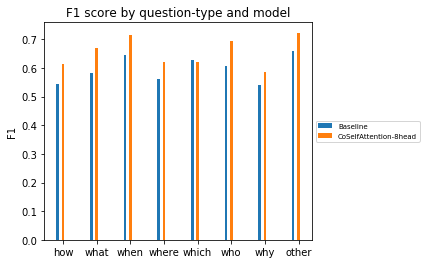

<Figure size 12800x9600 with 0 Axes>

In [150]:
%matplotlib inline
model_perf = collections.defaultdict(dict)

dataset_file = 'data/dev_eval.json'
eval_dataset = load_dev(dataset_file)

candidate_files = {'Baseline':'bidaf-baseline-03-03', 'CoSelfAttention-8head':'EightHeadSelfBest-02'}
n = len(candidate_files)
main_ques = ['how', 'what','when','where','which','who','why', 'other']
x = np.arange(len(main_ques))

fig, ax = plt.subplots()

width = 0.08
m = 0

for model, file in candidate_files.items():
    #print(model, file)
    f1_scores, em_scores, avna_scores = get_perf_by_question(file, eval_dataset)
    #print(f1_scores)
    model_perf[model]['f1'] = f1_scores
    model_perf[model]['em'] = em_scores
    model_perf[model]['avna'] = avna_scores
    f1 = []
    for ques in main_ques:
        f1.append(f1_scores[ques])
#         else:
#             f1.append(None)
    #f1.append(f1_scores['other'])
    ax.bar(x - 2*width + 4*m*width/n, f1[:], width, label=model)       
    #ax.bar(x - width/2 + m*width/2*n, f1[:], width, label=model)
    m += 1
#x_axis = main_ques[:] + ['other']    
#plt.legend(loc=2, prop={'size': 6})
ax.set_ylabel('F1')
ax.set_title('F1 score by question-type and model')
#print(main_ques)
#main_ques.insert(0, 'abc')
ax.set_xticks(x)
ax.set_xticklabels(main_ques)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=7) #(fontsize=7)
figure(figsize=(16, 12), dpi=800)
#fig.tight_layout()
fig.savefig('PerfQuestionType_twoModels.png')

plt.show()
 

Baseline bidaf-baseline-03-03
{'what': 0.5827436261871602, 'when': 0.6450747558551553, 'how': 0.5425629726625742, 'where': 0.561632949998601, 'why': 0.5403507949771226, 'which': 0.6268301350390904, 'who': 0.6084889375330553, 'other': 0.6595522404333873}
CoSelfAttention-8head EightHeadSelfBest-02
{'what': 0.6688432154507374, 'when': 0.7158482745324851, 'how': 0.6149850247401222, 'where': 0.6209830797088415, 'why': 0.5871939818526151, 'which': 0.6219793887704337, 'who': 0.6944669913419914, 'other': 0.723283788574953}


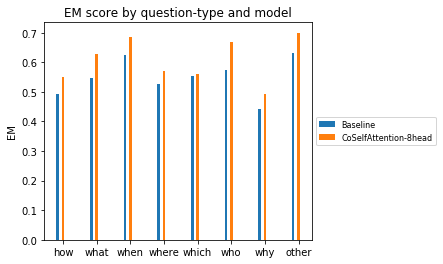

<Figure size 12800x9600 with 0 Axes>

In [152]:
%matplotlib inline
model_perf = collections.defaultdict(dict)

dataset_file = 'data/dev_eval.json'
eval_dataset = load_dev(dataset_file)

candidate_files = {'Baseline':'bidaf-baseline-03-03', 'CoSelfAttention-8head':'EightHeadSelfBest-02'}
n = len(candidate_files)
main_ques = ['how', 'what','when','where','which','who','why', 'other']
x = np.arange(len(main_ques))

fig, ax = plt.subplots()

width = 0.08
m = 0

for model, file in candidate_files.items():
    print(model, file)
    f1_scores, em_scores, avna_scores = get_perf_by_question(file, eval_dataset)
    print(f1_scores)
    model_perf[model]['f1'] = f1_scores
    model_perf[model]['em'] = em_scores
    model_perf[model]['avna'] = avna_scores
    em = []
    for ques in main_ques:
        em.append(em_scores[ques])
#         else:
#             f1.append(None)
    #f1.append(f1_scores['other'])
    ax.bar(x - 2*width + 4*m*width/n, em[:], width, label=model)         
    #ax.bar(x - width/2 + m*width/2*n, em[:], width, label=model)
    m += 1
#x_axis = main_ques[:] + ['other']    
#plt.legend(loc=2, prop={'size': 6})
ax.set_ylabel('EM')
ax.set_title('EM score by question-type and model')
#print(main_ques)
#main_ques.insert(0, 'abc')
ax.set_xticks(x)
ax.set_xticklabels(main_ques)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8) #(fontsize=7)
figure(figsize=(16, 12), dpi=800)
#fig.tight_layout()
fig.savefig('EMQuestionType_twoModels.png')

plt.show()

In [37]:
print(eval_dataset)

{'68cf05f67fd29c6f129fe2fb9': {'answers': ['France', 'France', 'France', 'France'], 'question': 'In what country is Normandy located?'}, 'f5fead9187d56af2bdbfcb921': {'answers': ['10th and 11th centuries', 'in the 10th and 11th centuries', '10th and 11th centuries', '10th and 11th centuries'], 'question': 'When were the Normans in Normandy?'}, 'f9183ead5bb93aaa12ea37245': {'answers': ['Denmark, Iceland and Norway', 'Denmark, Iceland and Norway', 'Denmark, Iceland and Norway', 'Denmark, Iceland and Norway'], 'question': 'From which countries did the Norse originate?'}, '1fc4da46445c2c1c2dc0ddeda': {'answers': ['Rollo', 'Rollo', 'Rollo', 'Rollo'], 'question': 'Who was the Norse leader?'}, '1be9fa378cbee6d9fa8b6ac78': {'answers': ['10th century', 'the first half of the 10th century', '10th', '10th'], 'question': 'What century did the Normans first gain their separate identity?'}, 'c42edddd0f45b968cc4c512e5': {'answers': [], 'question': "Who gave their name to Normandy in the 1000's and 11

# Context length

(array([ 140.,  956.,  946.,  924., 1140., 1020.,  952.]),
 array([  0,  60,  90, 100, 115, 140, 180, 650]),
 <a list of 7 Patch objects>)

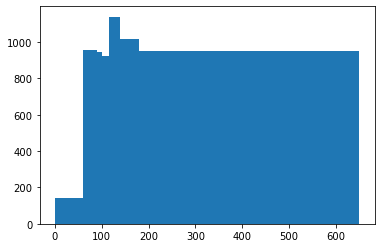

In [117]:
context = []
for x in eval_dataset:
    this_context = eval_dataset[x]['context']
    this_length = len(this_context.split(' '))
    context.append(this_length)
plt.hist(context, bins = [0, 60, 90, 100, 115, 140, 180, 650])

In [50]:
#context_types = ['0-50', '50-100', '100-150', '150-200', '200-250', '250-300', '300-350', '>350']
context_types = ['0-60', '60-90', '90-100', '100-115', '115-140', '140-180', '>180']

In [153]:
def context_type_analysis(pred_file, dataset):

    predictions = load_pred(pred_file)
    output_dict, dict_ques = eval_dicts(dataset, predictions, 1)
    #print(dict_ques)
    
    con_dist = collections.defaultdict(dict)
    for k, v in dict_ques.items():
        #print("k, v = ", k, v)
        context = v['context']
        this_length = len(context.split(' '))
        if this_length<=50:
            context_type = '0-50'
        elif this_length<=100:
            context_type = '50-100'
        elif this_length<=150:
            context_type = '100-150'
        elif this_length<=200:
            context_type = '150-200'
        elif this_length<=250:
            context_type = '200-250'
        elif this_length<=300:
            context_type = '250-300'
#         elif this_length<=350:
#             context_type = '300-350'
        else:
            context_type = '>300'
#         if this_length<=60:
#             context_type = '0-60'
#         elif this_length<=90:
#             context_type = '60-90'
#         elif this_length<=100:
#             context_type = '90-100'
#         elif this_length<=115:
#             context_type = '100-115'
#         elif this_length<=140:
#             context_type = '115-140'
#         elif this_length<=180:
#             context_type = '140-180'
# #         elif this_length<=350:
# #             context_type = '300-350'
#         else:
#             context_type = '>180'
            
        if context_type in con_dist:
            con_dist[context_type]['total'] +=1.0
            con_dist[context_type]['em1'] += v['EM']
            con_dist[context_type]['f11'] += v['F1']
            con_dist[context_type]['avna1'] += v['AvNA']
            
        else:
            con_dist[context_type]['total'] = 1.0
            con_dist[context_type]['em1'] = v['EM']
            con_dist[context_type]['f11'] = v['F1']
            con_dist[context_type]['avna1'] = v['AvNA']
    
    for fw,_ in con_dist.items():
        con_dist[fw]['em'] = con_dist[fw]['em1']*1.0/con_dist[fw]['total']
        con_dist[fw]['f1'] = con_dist[fw]['f11']*1.0/con_dist[fw]['total']
        con_dist[fw]['avna'] = con_dist[fw]['avna1']*1.0/con_dist[fw]['total']
    return con_dist

In [154]:
def get_perf_by_context(pred_file, eval_data):
    pred_file = 'data/'+file+'/dev_submission.csv'
    #print(pred_file)
    quest_dict = context_type_analysis(pred_file, eval_data)
    
    #context_types = ['0-50', '50-100', '100-150', '150-200', '200-250', '250-300', '>300'] #'300-350',
    f1_scores = {}
    em_scores = {}
    avna_scores = {}

    for ques in quest_dict:
        f1_scores[ques] = quest_dict[ques]['f1']
        em_scores[ques] = quest_dict[ques]['em']
        avna_scores[ques] = quest_dict[ques]['avna']
        #print(quest_dict[ques]['f1'], quest_dict[ques]['total'])
    # other question type
    return f1_scores, em_scores, avna_scores

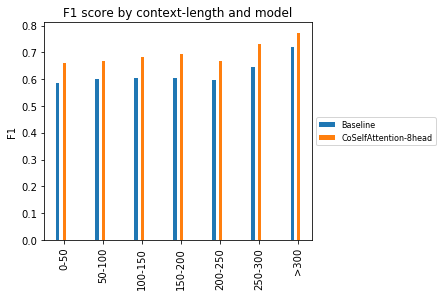

In [155]:
%matplotlib inline
model_perf = collections.defaultdict(dict)

dataset_file = 'data/dev_eval.json'
eval_dataset = load_dev(dataset_file)

candidate_files = {'Baseline':'bidaf-baseline-03-03', 'CoSelfAttention-8head':'EightHeadSelfBest-02'}

n = len(candidate_files)
context_types = ['0-50', '50-100', '100-150', '150-200', '200-250', '250-300', '>300'] # '>350']
# context_types = ['0-60', '60-90', '90-100', '100-115', '115-140', '140-180', '>180']
x = np.arange(len(context_types))

fig, ax = plt.subplots()

width = 0.08
m = 0

for model, file in candidate_files.items():
    #print(model, file)
    f1_scores, em_scores, avna_scores = get_perf_by_context(file, eval_dataset)
    #print(f1_scores)
    model_perf[model]['f1'] = f1_scores
    model_perf[model]['em'] = em_scores
    model_perf[model]['avna'] = avna_scores
    f1 = []
    for ques in context_types:
        if ques in f1_scores:
            f1.append(f1_scores[ques])
        else:
            f1.append(0)
    #f1.append(f1_scores['other'])
            
    ax.bar(x - 2*width + 4*m*width/n, f1[:], width, label=model)  #width/2 + m*width/2*n
    m += 1

ax.set_ylabel('F1')
ax.set_title('F1 score by context-length and model')
ax.set_xticks(x)
context
ax.set_xticklabels(context_types, rotation=90)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8) #(fontsize=7)
#figure(figsize=(16, 12), dpi=800)
#fig.tight_layout()
fig.savefig('PerfContextLength_twoModel_simpler.png')
#plt.xticks(rotation=90)
plt.show()

### By Answer Length

In [44]:
ans_types = ['0', '1-4', '4-5', '5-8', '8-10', '10-11', '11-13', '13-15', '15-17', '17-20', '20-25', '25-30' '30-40', '40-60', '>60']

(array([3168.,   72.,  227.,  292.,  231.,  112.,  250.,  224.,  204.,
         255.,  293.,  177.,  227.,  225.,  121.]),
 array([  0,   1,   4,   5,   8,  10,  11,  13,  15,  17,  20,  25,  30,
         40,  60, 150]),
 <a list of 15 Patch objects>)

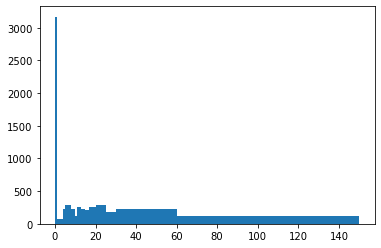

In [105]:
ans = []
for x in eval_dataset:
    total, count = 0., 0.
    for y in eval_dataset[x]['answers']:
        total += len(y)
        count += 1
    if count==0:
        ans.append(0.)
    else:
        ans.append(total/count)
plt.hist(ans, bins=[0, 1, 4, 5, 8, 10, 11, 13, 15, 17, 20, 25, 30, 40, 60, 150])

In [106]:
ans_types = ['0', '1-4', '4-5', '5-8', '8-10', '10-11', '11-13', '13-15', '15-17', '17-20', '20-25', '25-30' '30-40', '40-60', '>60']

In [159]:
def ans_type_analysis(pred_file, dataset):

    predictions = load_pred(pred_file)
    output_dict, dict_ques = eval_dicts(dataset, predictions, 1)
    #print(dict_ques)
    
    con_dist = collections.defaultdict(dict)
    for k, v in dict_ques.items():
        #print("k, v = ", k, v)
        context = v['answers']
        total, count = 0., 0.
        for ans in context:
            total += len(ans)
            count += 1.0
        if count==0:
            this_length = 0.
        else:
            this_length = total/count
            
        if this_length<=0:
            context_type = '0'
        elif this_length<=5:
            context_type = '1-5'
        elif this_length<=10:
            context_type = '6-10'
        elif this_length<=20:
            context_type = '11-20'
        else:
            context_type = '>20'
#         if this_length<=0:
#             context_type = '0'
#         elif this_length<=4:
#             context_type = '1-4'
#         elif this_length<=5:
#             context_type = '5'
#         elif this_length<=8:
#             context_type = '6-8'
#         elif this_length<=10:
#             context_type = '9-10'
#         elif this_length<=11:
#             context_type = '11'
#         elif this_length<=13:
#             context_type = '12-13'
#         elif this_length<=15:
#             context_type = '14-15'
#         elif this_length<=17:
#             context_type = '16-17'
#         elif this_length<=20:
#             context_type = '18-20'
#         elif this_length<=25:
#             context_type = '21-25'
#         elif this_length<=30:
#             context_type = '26-30'
#         elif this_length<=40:
#             context_type = '31-40'
#         elif this_length<=60:
#             context_type = '41-60'
#         else:
#             context_type = '>60'
            
        if context_type in con_dist:
            con_dist[context_type]['total'] +=1.0
            con_dist[context_type]['em1'] += v['EM']
            con_dist[context_type]['f11'] += v['F1']
            con_dist[context_type]['avna1'] += v['AvNA']
            
        else:
            con_dist[context_type]['total'] = 1.0
            con_dist[context_type]['em1'] = v['EM']
            con_dist[context_type]['f11'] = v['F1']
            con_dist[context_type]['avna1'] = v['AvNA']
    
    for fw,_ in con_dist.items():
        con_dist[fw]['em'] = con_dist[fw]['em1']*1.0/con_dist[fw]['total']
        con_dist[fw]['f1'] = con_dist[fw]['f11']*1.0/con_dist[fw]['total']
        con_dist[fw]['avna'] = con_dist[fw]['avna1']*1.0/con_dist[fw]['total']
    return con_dist

In [160]:
def get_perf_by_ans(pred_file, eval_data):
    pred_file = 'data/'+file+'/dev_submission.csv'
    #print(pred_file)
    quest_dict = ans_type_analysis(pred_file, eval_data)
    
    #context_types = ['0-50', '50-100', '100-150', '150-200', '200-250', '250-300', '>300'] #'300-350',
    f1_scores = {}
    em_scores = {}
    avna_scores = {}

    for ques in quest_dict:
        f1_scores[ques] = quest_dict[ques]['f1']
        em_scores[ques] = quest_dict[ques]['em']
        avna_scores[ques] = quest_dict[ques]['avna']
        #print(quest_dict[ques]['f1'], quest_dict[ques]['total'])
    # other question type
    return f1_scores, em_scores, avna_scores

{'0': 0.55849178214631, '6-10': 0.6715135605851275, '11-20': 0.6735717762826193, '>20': 0.5828946370872901, '1-5': 0.7727629513343799}
{'0': 0.6844988720592975, '6-10': 0.6949300967676213, '11-20': 0.6926633969555653, '>20': 0.6177914112185987, '1-5': 0.7434196755625325}


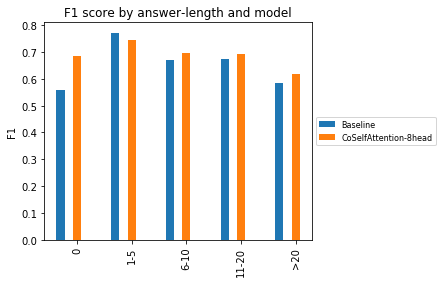

In [161]:
%matplotlib inline
model_perf = collections.defaultdict(dict)

dataset_file = 'data/dev_eval.json'
eval_dataset = load_dev(dataset_file)

candidate_files = {'Baseline':'bidaf-baseline-03-03', 'CoSelfAttention-8head':'EightHeadSelfBest-02'}
n = len(candidate_files)
# ans_types = ['0', '1-4', '5', '6-8', '9-10', '11', '12-13', '14-15', '16-17', '18-20'\
#              , '21-25', '26-30', '31-40', '41-60', '>60']
ans_types = ['0', '1-5', '6-10', '11-20', '>20']
x = np.arange(len(ans_types))

fig, ax = plt.subplots()

width = 0.15
m = 0

for model, file in candidate_files.items():
    #print(model, file)
    f1_scores, em_scores, avna_scores = get_perf_by_ans(file, eval_dataset)
    print(f1_scores)
    #print(f1_scores)
    model_perf[model]['f1'] = f1_scores
    model_perf[model]['em'] = em_scores
    model_perf[model]['avna'] = avna_scores
    f1 = []
    for ques in ans_types:
        if ques in f1_scores:
            f1.append(f1_scores[ques])
        else:
            f1.append(0)
    #f1.append(f1_scores['other'])
            
    ax.bar(x - 2*width + (4*m)*width/n, f1[:], width, label=model)
    m += 1

ax.set_ylabel('F1')
ax.set_title('F1 score by answer-length and model')
ax.set_xticks(x)
context
#ans_types[-1] = '>20'
ax.set_xticklabels(ans_types, rotation=90)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8) #(fontsize=7)
#figure(figsize=(16, 12), dpi=800)
#fig.tight_layout()
fig.savefig('PerfAnsLength_twoModels_simpler.png')
#plt.xticks(rotation=90)
plt.show()

# Difference analysis

In [121]:
candidate_files = {'Baseline':'bidaf-baseline-03-03', 'Coattention':'coSelfAttCharEmbbaseline-01', 'Coattention-4head':'bestMultiHeadCoatt-01', 'CoSelfAttention-8head':'EightHeadSelfBest-02'}

In [130]:
model_perf = collections.defaultdict(dict)
dataset_file = 'data/dev_eval.json'
eval_dataset = load_dev(dataset_file)
for model, file in candidate_files.items():
    pred_file = 'data/'+file+'/dev_submission.csv'
    predictions = load_pred(pred_file)
    output_dict, dict_ques = eval_dicts(eval_dataset, predictions, 1)
    print(output_dict)
    len(dict_ques)
    model_perf[model] = dict_ques

{'EM': 56.94841203159133, 'F1': 60.46591172739829, 'AvNA': 68.00537724752142}
{'EM': 64.2245000840195, 'F1': 67.45523482323745, 'AvNA': 74.08838850613343}
{'EM': 64.44295076457738, 'F1': 68.11305638070587, 'AvNA': 74.94538732986052}
{'EM': 64.10687279448832, 'F1': 67.9491148646383, 'AvNA': 74.69332885229373}


In [133]:
baseline = model_perf['Baseline']
print(len(baseline))
best_model = model_perf['CoSelfAttention-8head']
print(len(best_model))
for key in best_model:
    best_model[key]['baseline_prediction'] = baseline[key]['prediction']
    best_model[key]['baseline_F1'] = baseline[key]['F1']
    best_model[key]['baseline_EM'] = baseline[key]['EM']
    best_model[key]['baseline_AvNA'] = baseline[key]['AvNA']
print(len(best_model))
#print(best_model.keys())

5951
5951
5951
dict_keys(['001fefa37a13cdd53fd82f617', '00415cf9abb539fbb7989beba', '00a4cc38bd041e9a4c4e545ff', '00bafbca5f0d7f61e00a41cb5', '00d60faa383c8a6beffbc2bff', '00e4a6dbb04af0134ee29ce6f', '011cbedf80fae8444eb3c95ce', '01541dd84dafb8143adaa74aa', '0170d2c5639a82ee5e1744cfd', '019ccc77acb5f4a5d1f24cf70', '01ce0faab6e0caffd706a4a65', '01da80ae47c64d4c87757fd86', '01db6a7ac8affb635ebcd3d7c', '01dbd1dcf10aceceddd7ecc7c', '021dcacbf7ad7d6c6cd05ab71', '025e1b8c06cefd2e8872120d2', '025f8b7af1cecf29bb627cf0d', '028fba9bb26fcdb32ee8a0a47', '0297d9cca636f0fbd47b70b76', '02a1834dfeda76d6f5ef4ab0e', '02a8e18f236d42d2d08071cf9', '02c34aacadeeb9ee3f4fd1cc0', '02f458e6f678bf80dd8e33fdf', '02f9626af8cf0bf08d1aaec9f', '02fcabb0e9c02bca07c5f9b0b', '030a8e486b09b5d1a40e6c9b4', '033a2bbe410fbc6443ddb7adb', '033b660b1b450c098d0efbd8d', '036cb20d82edb8eded6fbeb4b', '036d96b028fffaeaabcb28b3e', '0387bf2be43e4a64a389bc736', '03acfc4dca4cb9ae52fded5db', '03be6ec8352b679a0c5f5f246', '03faf6eebfd1dda0

In [136]:
with open('comparison.csv', 'w', newline='', encoding = 'utf-8') as csvfile:
    fieldnames = ['QuestionID', 'context', 'question', 'answers', 'model_prediction', 'baseline_prediction', 'model_F1', 'baseline_F1']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for key in best_model:
        writer.writerow({'QuestionID': key, 'context': best_model[key]['context'], 'question':best_model[key]['question']\
                        , 'answers': best_model[key]['answers'], 'model_prediction': best_model[key]['prediction']\
                        , 'baseline_prediction':best_model[key]['baseline_prediction'], 'model_F1' : best_model[key]['F1']\
                        , 'baseline_F1':best_model[key]['baseline_F1']})

In [138]:
with open('comparison_differences.csv', 'w', newline='', encoding = 'utf-8') as csvfile:
    fieldnames = ['QuestionID', 'context', 'question', 'answers', 'model_prediction', 'baseline_prediction', 'model_F1', 'baseline_F1']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for key in best_model:
        if best_model[key]['prediction']!=best_model[key]['baseline_prediction']:
            writer.writerow({'QuestionID': key, 'context': best_model[key]['context'], 'question':best_model[key]['question']\
                            , 'answers': best_model[key]['answers'], 'model_prediction': best_model[key]['prediction']\
                            , 'baseline_prediction':best_model[key]['baseline_prediction'], 'model_F1' : best_model[key]['F1']\
                            , 'baseline_F1':best_model[key]['baseline_F1']})

In [139]:
with open('comparison_differences_positive.csv', 'w', newline='', encoding = 'utf-8') as csvfile:
    fieldnames = ['QuestionID', 'context', 'question', 'answers', 'model_prediction', 'baseline_prediction', 'model_F1', 'baseline_F1']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for key in best_model:
        if best_model[key]['prediction']!=best_model[key]['baseline_prediction'] and (best_model[key]['F1']>best_model[key]['baseline_F1']):
            writer.writerow({'QuestionID': key, 'context': best_model[key]['context'], 'question':best_model[key]['question']\
                            , 'answers': best_model[key]['answers'], 'model_prediction': best_model[key]['prediction']\
                            , 'baseline_prediction':best_model[key]['baseline_prediction'], 'model_F1' : best_model[key]['F1']\
                            , 'baseline_F1':best_model[key]['baseline_F1']})

In [162]:
with open('comparison_differences_negative.csv', 'w', newline='', encoding = 'utf-8') as csvfile:
    fieldnames = ['QuestionID', 'context', 'question', 'answers', 'model_prediction', 'baseline_prediction', 'model_F1', 'baseline_F1']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for key in best_model:
        if best_model[key]['prediction']!=best_model[key]['baseline_prediction'] and (best_model[key]['F1']<best_model[key]['baseline_F1']):
            writer.writerow({'QuestionID': key, 'context': best_model[key]['context'], 'question':best_model[key]['question']\
                            , 'answers': best_model[key]['answers'], 'model_prediction': best_model[key]['prediction']\
                            , 'baseline_prediction':best_model[key]['baseline_prediction'], 'model_F1' : best_model[key]['F1']\
                            , 'baseline_F1':best_model[key]['baseline_F1']})

# No-Answer plus Answer

In [208]:
candidate_files = {'CoSelfAttention-8head':'EightHeadSelfBest-02', 'NoAnswer':'noAnswerFresh-02'}

In [212]:
model_perf = collections.defaultdict(dict)
dataset_file = 'data/dev_eval.json'
eval_dataset = load_dev(dataset_file)
for model, file in candidate_files.items():
    pred_file = 'data/'+file+'/dev_submission.csv'
    predictions = load_pred(pred_file)
    output_dict, dict_ques = eval_dicts(eval_dataset, predictions, 1)
    print(output_dict)
    len(dict_ques)
    model_perf[model] = dict_ques

{'EM': 64.10687279448832, 'F1': 67.9491148646383, 'AvNA': 74.69332885229373}
{'EM': 64.30851957654176, 'F1': 67.52918027274299, 'AvNA': 74.13880020164679}


In [222]:
# dataset_file = 'data/dev_eval.json'
# eval_dataset = load_dev(dataset_file)
model_pred = collections.defaultdict(dict)
for model, file in candidate_files.items():
    pred_file = 'data/'+file+'/dev_submission.csv'
    model_pred[model] = load_pred(pred_file)

In [217]:
for key in model_pred['CoSelfAttention-8head']:
    if model_pred['CoSelfAttention-8head'][key] == '':
        print(model_pred['CoSelfAttention-8head'][key])

In [223]:
best_model = model_pred['CoSelfAttention-8head']
noanswer = model_pred['NoAnswer']
#print(best_model)
for key in best_model:
    if best_model[key] != '':
        best_model[key] = noanswer[key]
print(len(best_model))
#print(best_model.keys())

5951


In [224]:
perf, _ = eval_dicts(eval_dataset, best_model, 1)
print(perf)

{'EM': 67.2996135103344, 'F1': 70.2514352634124, 'AvNA': 75.9200134431188}


In [210]:
perf, _ = eval_dicts(eval_dataset, model_pred['CoSelfAttention-8head'], 1)
print(perf)

{'EM': 64.10687279448832, 'F1': 67.9491148646383, 'AvNA': 74.69332885229373}


In [226]:
with open('noanswer_dev_submission.csv', 'w', newline='', encoding = 'utf-8') as csvfile:
    fieldnames = ['ID', 'prediction']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for key in best_model:
        writer.writerow({'ID': key, 'prediction': best_model[key]})

In [211]:
perf_ = eval_dicts(eval_dataset, model_pred['NoAnswer'], 1)
print(perf)

{'EM': 64.10687279448832, 'F1': 67.9491148646383, 'AvNA': 74.69332885229373}


### Coattention 4 head plus NoAnswer

In [231]:
candidate_files = {'Coattention-4head':'bestMultiHeadCoatt-01', 'NoAnswer':'noAnswerFresh-02'}

In [232]:
model_perf = collections.defaultdict(dict)
dataset_file = 'data/dev_eval.json'
eval_dataset = load_dev(dataset_file)
for model, file in candidate_files.items():
    pred_file = 'data/'+file+'/dev_submission.csv'
    predictions = load_pred(pred_file)
    output_dict, dict_ques = eval_dicts(eval_dataset, predictions, 1)
    print(output_dict)
    len(dict_ques)
    model_perf[model] = dict_ques

{'EM': 64.44295076457738, 'F1': 68.11305638070587, 'AvNA': 74.94538732986052}
{'EM': 64.30851957654176, 'F1': 67.52918027274299, 'AvNA': 74.13880020164679}


In [233]:
# dataset_file = 'data/dev_eval.json'
# eval_dataset = load_dev(dataset_file)
model_pred = collections.defaultdict(dict)
for model, file in candidate_files.items():
    pred_file = 'data/'+file+'/dev_submission.csv'
    model_pred[model] = load_pred(pred_file)

In [217]:
for key in model_pred['Coattention-4head']:
    if model_pred['Coattention-4head'][key] == '':
        print(model_pred['Coattention-4head'][key])

In [234]:
best_model = model_pred['Coattention-4head']
noanswer = model_pred['NoAnswer']
#print(best_model)
for key in best_model:
    if best_model[key] != '':
        best_model[key] = noanswer[key]
print(len(best_model))
#print(best_model.keys())

5951


In [235]:
perf, _ = eval_dicts(eval_dataset, best_model, 1)
print(perf)

{'EM': 67.28280961182995, 'F1': 70.1780007907173, 'AvNA': 75.9200134431188}


In [236]:
with open('noanswer_coatt4head_dev_submission.csv', 'w', newline='', encoding = 'utf-8') as csvfile:
    fieldnames = ['Id', 'Predicted']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for key in best_model:
        writer.writerow({'Id': key, 'Predicted': best_model[key]})

## Appendix

In [128]:
f1_scores = [0]*(len(main_ques)+1)
em_scores = [0]*(len(main_ques)+1)
avna_scores = [0]*(len(main_ques)+1)

total, f1, em, avna = 0, 0, 0, 0
for ques in quest_dict:
    if ques in main_ques:
        f1_scores[que2idx[ques]] = quest_dict[ques]['f1']
        em_scores[que2idx[ques]] = quest_dict[ques]['em']
        avna_scores[que2idx[ques]] = quest_dict[ques]['avna']
        #print(quest_dict[ques]['f1'], quest_dict[ques]['total'])
    else:
        total += quest_dict[ques]['total']
        f1 += quest_dict[ques]['total']*quest_dict[ques]['f1']
        em += quest_dict[ques]['total']*quest_dict[ques]['em']
        avna += quest_dict[ques]['total']*quest_dict[ques]['avna']
#for ques in x_axis:
    
f1_scores[-1] = f1/total
em_scores[-1] = em/total
avna_scores[-1] = avna/total

In [39]:
# data = json.load(open('data/dev_eval.json'))
# keys = {str(x) for x in range(1, 10)}
# mini_data = {k:v for k,v in data.items() if k in keys}
# pprint(mini_data)
data = load_dev('data/dev_eval.json')
keys_list = []
for k, v in data.items():
    keys_list.append(k)
    if len(keys_list)==10:
        break
print(keys_list)
# keys = {str(x) for x in range(1, 10)}
# mini_data = {k:v for k,v in data.items() if k in keys}
# pprint(mini_data)
# pprint(data)

['68cf05f67fd29c6f129fe2fb9', 'f5fead9187d56af2bdbfcb921', 'f9183ead5bb93aaa12ea37245', '1fc4da46445c2c1c2dc0ddeda', '1be9fa378cbee6d9fa8b6ac78', 'c42edddd0f45b968cc4c512e5', 'd583847c96cbbbfaaa99dfcad', 'e06fbbdb50af7ab3faefde618', 'cbb48eaacbbbfcccefb7aab7f', '6d2fff36bcac0ea0e689a5a31']
